In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, KFold
from catboost import CatBoostRegressor

In [2]:
df = pd.read_parquet('dataset/cleaned_listings.gzip')

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

amenities = mlb.fit_transform(list(df['amenities']))

In [4]:
amenities = pd.DataFrame(amenities, columns = mlb.classes_)

In [5]:
# Sum the columns and filter out values less than the threshold
threshold = 1000
column_sums = amenities.sum().where(lambda x: x > threshold).dropna().reset_index()

# Rename the index column to the original column names
column_sums.rename(columns={'index': 'name', 0: 'sum'}, inplace=True)

# Print the resulting DataFrame
amenities = amenities[column_sums['name']]

In [6]:
df = df.drop(columns = 'amenities')
df = df.join(amenities)

<AxesSubplot:xlabel='price', ylabel='neighbourhood'>

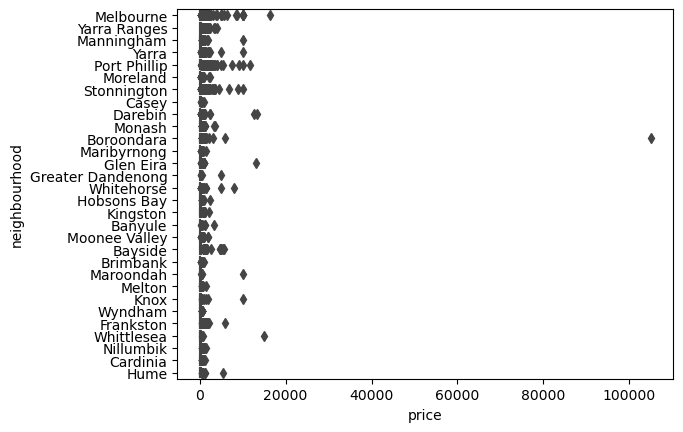

In [10]:
import seaborn as sns
sns.boxplot(data=df, x ='price', y='neighbourhood')

Dataset is affected by some big outliers.

To deal with these we will group by neighbourhood and replace any prices that sit outside the .05 and .95 percentile with the respective limit.

In [23]:
# Group the data by the 'neighbourhood' column
grouped = df.groupby('neighbourhood')

# For each group, compute the .05 and .95 quantiles for the 'price' column
quantiles = grouped['price'].quantile([.05, .95])

# Iterate over each group
for name, group in grouped:
    # Find the lower and upper bounds for the group
    lower_bound = quantiles.loc[name][.05]
    upper_bound = quantiles.loc[name][.95]

    # Replace outliers in the 'price' column with the lower bound
    group.loc[group['price'] < lower_bound, 'price'] = lower_bound
    # Replace outliers in the 'price' column with the upper bound
    group.loc[group['price'] > upper_bound, 'price'] = upper_bound

    # Update the original df with the modified group
    df.update(group)


<AxesSubplot:xlabel='price', ylabel='neighbourhood'>

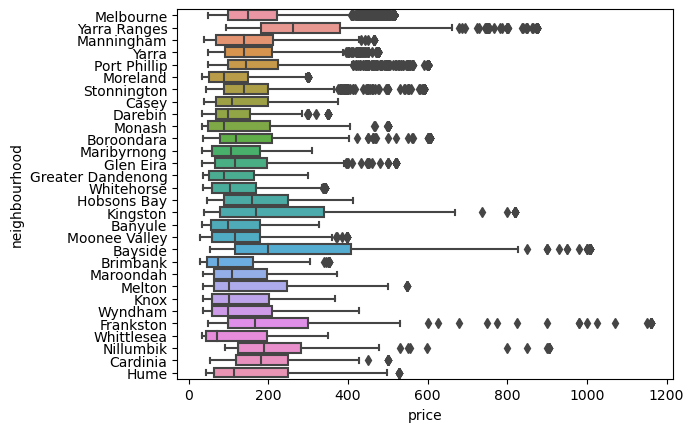

In [24]:
sns.boxplot(data=df, x ='price', y='neighbourhood')

# Feature scaling

In [27]:
df.describe()

,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,shared_bathroom,bathrooms,AC - split type ductless system,Air conditioning,...,Stove,TV,TV with standard cable,Toaster,Washer,Wifi,Wine glasses,Cooking basics,Hair dryer,Washer
count,18236.000000,17487.000000,18012.000000,18236.000000,18236.000000,18236.000000,18236.000000,18219.000000,18236.000000,18236.000000,...,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.00000,18236.000000,18236.000000
mean,3.521935,1.703494,2.068177,180.838051,7.113183,649.881443,0.168019,1.354438,0.066846,0.666923,...,0.436773,0.643507,0.077978,0.257951,0.427890,0.886214,0.228559,0.06054,0.586587,0.294582
std,2.326635,1.015087,1.582592,142.529752,37.076793,889.333205,0.373894,0.658218,0.249762,0.471327,...,0.496000,0.478976,0.268144,0.437519,0.494786,0.317560,0.419916,0.23849,0.492459,0.455867
min,1.000000,1.000000,1.000000,28.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,85.000000,1.000000,89.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
50%,3.000000,1.000000,2.000000,142.000000,2.000000,999.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000
75%,4.000000,2.000000,3.000000,223.000000,3.000000,1125.000000,0.000000,1.500000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000
max,16.000000,15.000000,24.000000,1160.000000,1125.000000,99999.000000,1.000000,10.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


**Features to scale**
* accomodates
* bedrooms
* beds
* min_nights
* max_nights
* bathrooms

Most these columns have afew outliers so we will use standard scaling instead of min-max

In [31]:
from sklearn.preprocessing import StandardScaler

#select columns to scale
columns_to_scale = df[['accommodates','bedrooms','beds','minimum_nights','maximum_nights', 'bathrooms']]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the numerical columns
scaler.fit(columns_to_scale)

# Scale the numerical columns
scaled_columns = scaler.transform(columns_to_scale)

In [33]:
# Convert the scaled columns back to a DataFrame
scaled_df = pd.DataFrame(scaled_columns, columns=columns_to_scale.columns)

# Concatenate the scaled numerical columns with the non-numerical columns
df = pd.concat([scaled_df, df.drop(columns=columns_to_scale.columns)], axis=1)

In [40]:
df.describe()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,bathrooms,price,shared_bathroom,AC - split type ductless system,Air conditioning,...,Stove,TV,TV with standard cable,Toaster,Washer,Wifi,Wine glasses,Cooking basics,Hair dryer,Washer
count,1.823600e+04,1.748700e+04,1.801200e+04,1.823600e+04,1.823600e+04,1.821900e+04,18236.000000,18236.000000,18236.000000,18236.000000,...,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.000000,18236.00000,18236.000000,18236.000000
mean,5.610778e-17,-4.550854e-17,7.889660e-17,2.181969e-17,-1.870259e-17,8.736021e-17,180.838051,0.168019,0.066846,0.666923,...,0.436773,0.643507,0.077978,0.257951,0.427890,0.886214,0.228559,0.06054,0.586587,0.294582
std,1.000027e+00,1.000029e+00,1.000028e+00,1.000027e+00,1.000027e+00,1.000027e+00,142.529752,0.373894,0.249762,0.471327,...,0.496000,0.478976,0.268144,0.437519,0.494786,0.317560,0.419916,0.23849,0.492459,0.455867
min,-1.083971e+00,-6.930577e-01,-6.749729e-01,-1.648835e-01,-7.296469e-01,-2.057790e+00,28.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-6.541536e-01,-6.930577e-01,-6.749729e-01,-1.648835e-01,-6.306937e-01,-5.384953e-01,85.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
50%,-2.243364e-01,-6.930577e-01,-4.308039e-02,-1.379117e-01,3.925729e-01,-5.384953e-01,142.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000
75%,2.054807e-01,2.921073e-01,5.888121e-01,-1.109399e-01,5.342560e-01,2.211521e-01,223.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000
max,5.363286e+00,1.309925e+01,1.385855e+01,3.015141e+01,1.117150e+02,1.389481e+01,1160.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


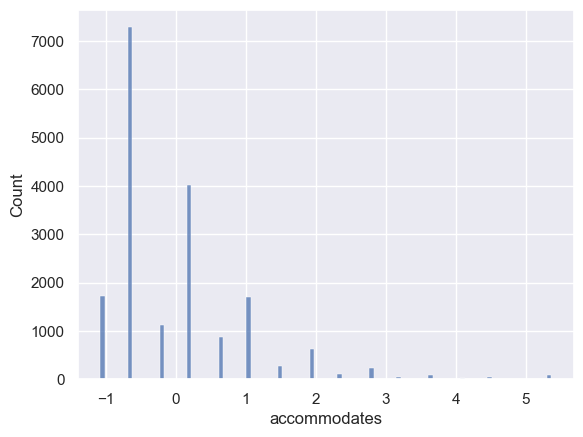

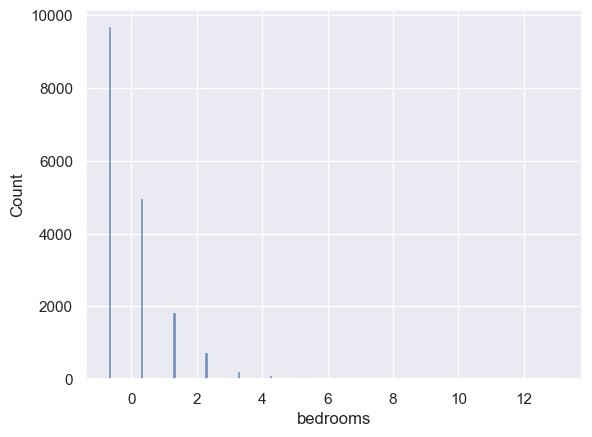

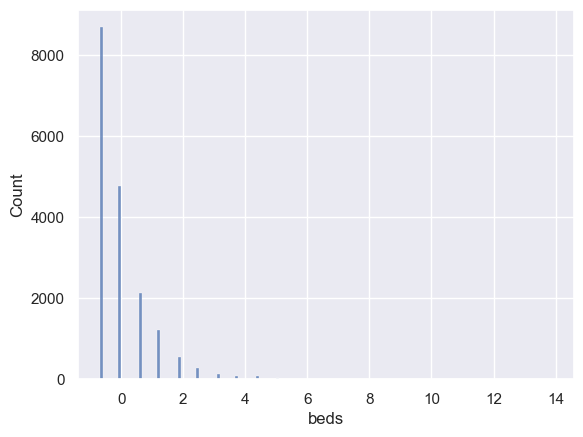

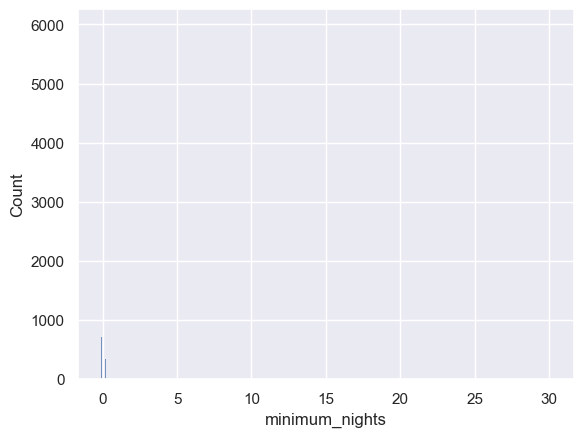

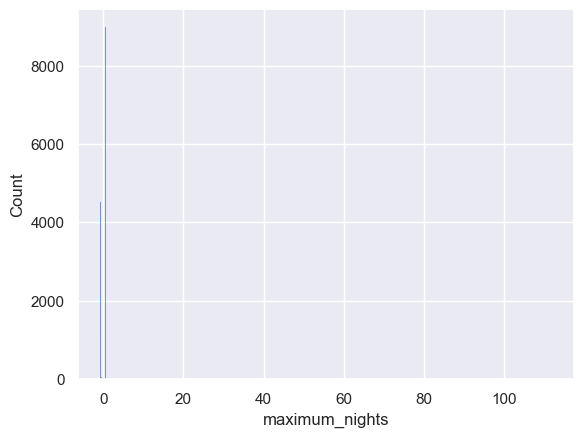

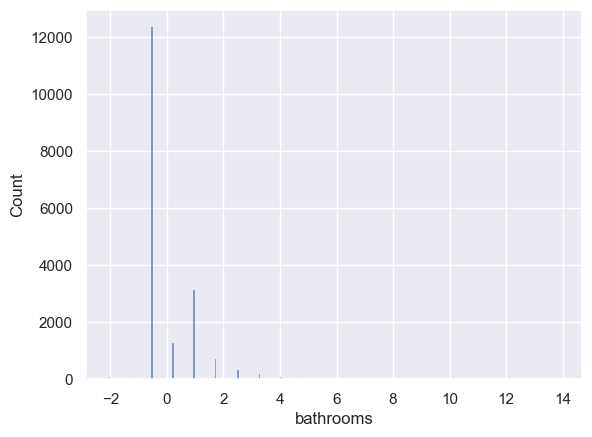

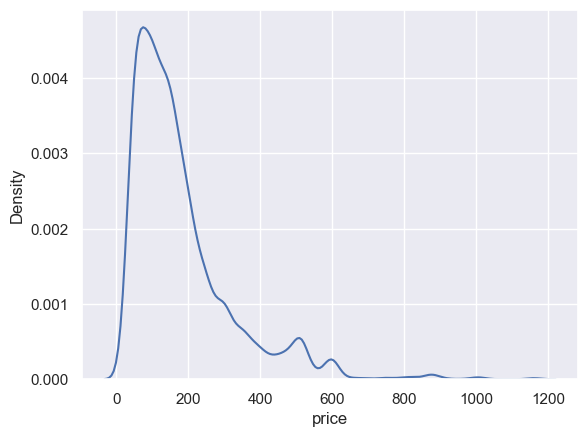

In [122]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt

num_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'bathrooms', 'price']

# set a grey background 
sns.set_theme(style="darkgrid")


for col in num_columns:
    if col == 'price':
        sns.kdeplot(data=df, x=col)
        plt.show()
    else:
        sns.histplot(data=df, x=col)
        plt.show()

# Missing Values

Catboost regressor will deal with NA values automatically

# Train the Model

In [75]:
# categorical features must be str or int for catboost model

df[cat_features] = df[cat_features].astype('str')

In [76]:
X = df.drop(columns='price')
y = df['price'].copy()

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)

In [78]:
all_columns = list(df.columns)

cat_features = []
for column in all_columns:
    if column not in num_columns:
        cat_features.append(column)

In [79]:
model = CatBoostRegressor(iterations=2000, 
                          learning_rate=0.05,
                          depth=10,
                          l2_leaf_reg=15,
                          loss_function='Huber:delta=1.6',
                          # save_snapshot='
                         )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=250,
    eval_set=(X_validation, y_validation),
    plot=True
)

C:\Users\tberv\anaconda3\envs\airbnb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 256.2424917	test: 253.6628275	best: 253.6628275 (0)	total: 172ms	remaining: 5m 43s
250:	learn: 114.7266434	test: 113.3731487	best: 113.3731487 (250)	total: 14s	remaining: 1m 37s
500:	learn: 107.1859440	test: 107.3598592	best: 107.3598592 (500)	total: 28.6s	remaining: 1m 25s
750:	learn: 102.8669551	test: 104.1436753	best: 104.1436753 (750)	total: 43.2s	remaining: 1m 11s
1000:	learn: 99.6863805	test: 101.7350797	best: 101.7350797 (1000)	total: 58.1s	remaining: 57.9s
1250:	learn: 97.1119140	test: 99.8135512	best: 99.8135512 (1250)	total: 1m 12s	remaining: 43.7s
1500:	learn: 94.9639840	test: 98.2551308	best: 98.2551308 (1500)	total: 1m 27s	remaining: 29.2s
1750:	learn: 93.0546465	test: 96.9140906	best: 96.9140906 (1750)	total: 1m 42s	remaining: 14.6s
1999:	learn: 91.3515242	test: 95.6871292	best: 95.6871292 (1999)	total: 1m 57s	remaining: 0us

bestTest = 95.68712923
bestIteration = 1999



# Feature importance

Look at feature importance and chose only the features that help the model

In [80]:
importances = model.get_feature_importance()

sorted_importances = sorted(importances, reverse=True)

threshold = sorted_importances[len(sorted_importances) // 2]

selected_features = [f for i, f in enumerate(X_train.columns) if importances[i] >= threshold]

In [81]:
# new list of categorical features in the new df
all_columns = list(X_train[selected_features].columns)
num_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'bathrooms', 'price']

cat_features_50 = []
for column in all_columns:
    if column not in num_columns:
        cat_features_50.append(column)

# Train new model

In [82]:
# train model with top 50 features
model_2 = CatBoostRegressor(iterations=2000, 
                          learning_rate=0.08,
                          depth=10,
                          l2_leaf_reg=15,
                          loss_function='Huber:delta=1.1',
                          #save_snapshot=True
                         )

model_2.fit(
    X_train[selected_features], y_train,
    cat_features=cat_features_50,
    verbose=250,
    eval_set=(X_validation[selected_features], y_validation),
    plot=True
)




C:\Users\tberv\anaconda3\envs\airbnb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 193.9327340	test: 191.9605622	best: 191.9605622 (0)	total: 48ms	remaining: 1m 35s
250:	learn: 72.4970999	test: 71.4710449	best: 71.4710449 (250)	total: 12.4s	remaining: 1m 26s
500:	learn: 68.7454642	test: 68.4722540	best: 68.4722540 (500)	total: 25.3s	remaining: 1m 15s
750:	learn: 66.5023236	test: 66.8687346	best: 66.8687346 (750)	total: 38.2s	remaining: 1m 3s
1000:	learn: 64.7893334	test: 65.6692655	best: 65.6692655 (1000)	total: 51.2s	remaining: 51.1s
1250:	learn: 63.3772275	test: 64.7006883	best: 64.7006883 (1250)	total: 1m 4s	remaining: 38.4s
1500:	learn: 62.1436798	test: 63.9304664	best: 63.9304664 (1500)	total: 1m 17s	remaining: 25.7s
1750:	learn: 61.0563213	test: 63.2592738	best: 63.2592738 (1750)	total: 1m 30s	remaining: 12.8s
1999:	learn: 60.0822091	test: 62.7053093	best: 62.7053093 (1999)	total: 1m 43s	remaining: 0us

bestTest = 62.70530928
bestIteration = 1999



# Hyperparameter Tuning

In [130]:
model_3 = CatBoostRegressor(loss_function='Huber:delta=1.1',
                            cat_features=cat_features_50,
                            verbose=False,
                            thread_count=-1,
                            early_stopping_rounds=5
                           )
                            

grid = {'learning_rate': [0.1, 0.13],
        'depth': [3,7,9],
        'l2_leaf_reg': [9, 13, 17],
        'iterations': [1500]
       }

randomized_search_result = model_3.randomized_search(grid,
                                                   X=X_train[selected_features],
                                                   y=y_train,
                                                   plot=True,
                                                   n_iter=5,
                                                   cv=5)


C:\Users\tberv\anaconda3\envs\airbnb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 60.18223631
bestIteration = 1499

0:	loss: 60.1822363	best: 60.1822363 (0)	total: 1m 16s	remaining: 5m 6s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 59.78891471
bestIteration = 1328

1:	loss: 59.7889147	best: 59.7889147 (1)	total: 2m 24s	remaining: 3m 36s

bestTest = 62.18373903
bestIteration = 1499

2:	loss: 62.1837390	best: 59.7889147 (1)	total: 3m 39s	remaining: 2m 26s

bestTest = 61.01491185
bestIteration = 1499

3:	loss: 61.0149119	best: 59.7889147 (1)	total: 5m 2s	remaining: 1m 15s

bestTest = 62.121202
bestIteration = 1499

4:	loss: 62.1212020	best: 59.7889147 (1)	total: 6m 25s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 63.61145441
bestIteration = 1426

Training on fold [1/5]

bestTest = 64.69676241
bestIteration = 1301

Training on fold [2/5]

bestTest = 65.12601789
bestIteration = 1085

Training on fold [3/5]

bestTest = 61.63913049
bestIteration = 1498

Training on fold [4/5]

bestTest = 60.23277144
bestIter

In [158]:
best_params = randomized_search_result['params']
best_params

{'depth': 7, 'l2_leaf_reg': 9, 'iterations': 1500, 'learning_rate': 0.13}

In [169]:
best_model = CatBoostRegressor(depth=7,
                               l2_leaf_reg=9,
                               iterations=2000,
                               learning_rate=0.13,
                               cat_features=cat_features_50,
                               thread_count=-1,
                               loss_function='Huber:delta=1.1')


best_model.fit(X=X_train[selected_features],
               y=y_train,
               plot=True,
               eval_set=(X_validation[selected_features],y_validation),
               verbose=False
               )

C:\Users\tberv\anaconda3\envs\airbnb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Shap Values

Using shap values library we can explore the features that have the most impact in our model.

In [201]:
from catboost import Pool

train_pool = Pool(
    data=X_train[selected_features],
    label=y_train, 
    cat_features=cat_features_50
)

validation_pool = Pool(
    data=X_validation[selected_features],
    label=y_validation,
    cat_features=cat_features_50
)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [202]:
shap_values = best_model.get_feature_importance(
    validation_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(3648, 49)


In [203]:
!pip install shap
import shap

In [219]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation[selected_features].iloc[1,:])

In [217]:
shap.force_plot(expected_value, shap_values[3600,:], X_validation[selected_features].iloc[1,:])

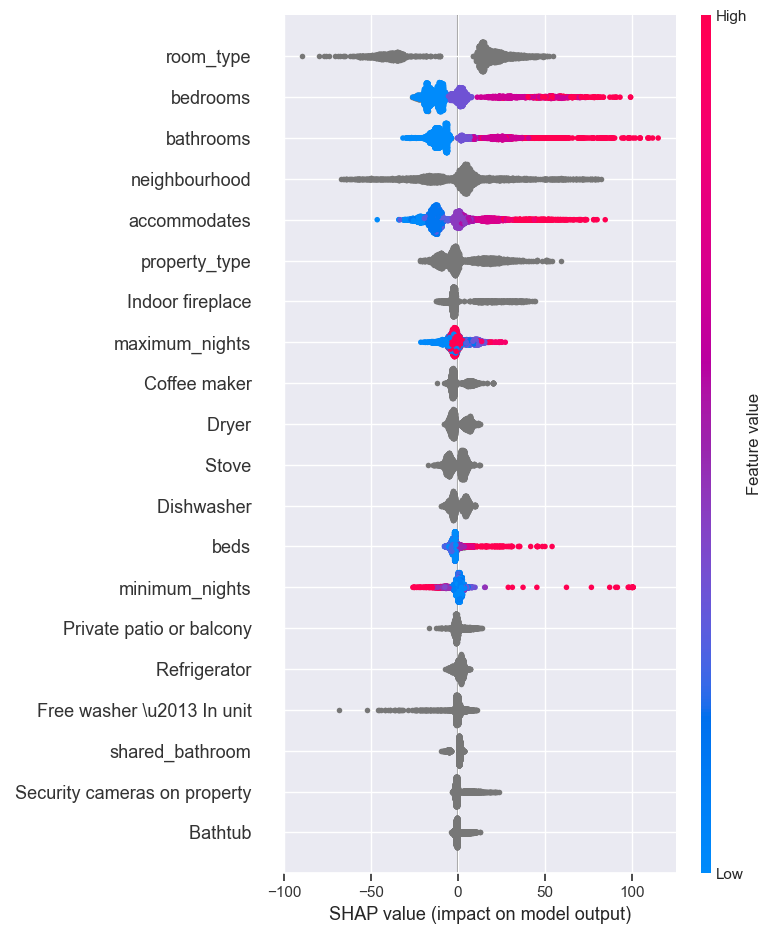

In [205]:
shap.summary_plot(shap_values, X_validationselected_features)

The base value that all predictions start at is $161.1.

In the first visual we see a prediction of $142.43. The biggest positive feautre was the room_type and the biggest negative feature was the number of bedrooms and bathrooms.

The second visual predicts $259.52, with the biggest positive feature being room type and number bathrooms. The biggest negative feature being beds and bedrooms. 



In [207]:
from joblib import dump

dump(model, "catboost_reg_model.pkl")

['catboost_reg_model.pkl']